# MovieLens Recommendation System

# 1. Business Understanding
## a. Introduction
The MovieLens dataset is a valuable resource for building and enhancing recommendation systems, and it can serve various business goals. The goal of a recommendation system is to expose people to items that they will like. It predicts the future preference of a set of items for a user, and recommends the top items from this set. In today's world, due to the internet and its global reach, people have more options to choose from than ever before.

Recommendation systems are a popular way for users to sort through millions of items to find the ones that are customized exactly for them. Recommendation systems cast a direct impact on profitability and customer satisfaction for most businesses today. With the nearly limitless options consumers have for products online, they need some guidance. Here, the MovieLens recommendation system helps in suggesting the movies which a customer might be interested in considering their past ratings history. 

The type of approach we will use for this recommendation system is the personalized recommendation system where we make use of different similarity metrics to determine how "similar" items are to one another. The most common similarity metric we will use for this project is the cosine similarity.
 
## b. Problem Statement
To develop an effective movie recommendation system that leverages collaborative filtering and content-based filtering techniques based on user ratings and movie attributes. The goal is to provide personalized movie recommendations to users, addressing the cold start problem for new users and enhancing the user experience by suggesting movies tailored to their preferences and viewing history.

## c. Main Objective
The main objective is to create a recommendation system that accurately suggests movies to users based on their historical ratings and preferences.

## d. Specific Objectives
- To increase user engagement and satisfaction by delivering movie suggestions that align with the users' interests and preferences.
- To implement thorough evaluation metrics to measure the performance of the recommendation system and optimize the algorithms for better accuracy and relevance of recommendations.
- To utilize movie attributes such as genre to enhance recommendations through content-based filtering, providing a broader range of suggestions.
- To utilize user ratings and interactions to identify patterns and preferences, allowing for improved recommendations that align with individual tastes.
- To develop strategies to mitigate the cold start problem by providing meaningful recommendations to new users who have not provided any ratings yet.

## e. Defining the metric for success

Our model will be a success if it is able to provide the top 5 movie recommendations to a user based on their ratings of other movies.

## f. Experimental Design
1. Introduction
2. Importing the necessary libraries
3. Reading the data
4. Data Wrangling
5. Exploratory Data Analysis
6. Implementing the solution
7. Conclusions
8. Recommendations

## g. Data Understanding
The data that was used in this project was colected from:
- https://grouplens.org/datasets/movielens/latest/

We used the small dataset containing 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users.

# 2. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.linalg import svds
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# 3. Reading The Data

In [2]:
# Loading the links dataset
links_data = pd.read_csv("links.csv")
links_data.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
# Loading the movies dataset
movies_data = pd.read_csv("movies.csv")
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Loading the ratings dataset
ratings_data = pd.read_csv("ratings.csv")
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
ratings_data.rating.value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [6]:
# Loading the tags dataset
tags_data = pd.read_csv("tags.csv")
tags_data.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


# 4. Data Wrangling
1.) checking for missing values

In [7]:
movies_data.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [8]:
ratings_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
links_data.isnull().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [10]:
# Dropping missing values from the links dataframe
links_data.dropna(subset = ['tmdbId'])

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [11]:
tags_data.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

2.) previewing the data types in the datasets

In [12]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [13]:
# Checking for duplicates in the movies dataset
movies_data.movieId.nunique()

9742

In [14]:
links_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [15]:
# Checking for duplicates in the links dataset
links_data.movieId.nunique()

9742

In [16]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [17]:
tags_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


# 5. Exploratory Data Analysis

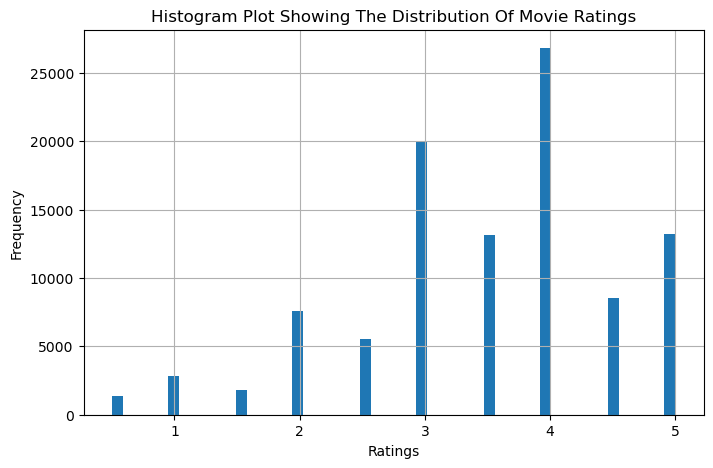

In [20]:
# showing the distribution of ratings via histogram
plt.figure(figsize=(8, 5))
plt.hist(ratings_data['rating'], bins=50)
plt.title('Histogram Plot Showing The Distribution Of Movie Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 6. Implementing the solution

### a.) Item based filtering

This is when someone looks at the similarity of one vector of an item's ratings from every user and compares it to every other item. Now, the most similar items can be recommended to those that a customer has liked. This is similar to a content-based recommendation, except we are not looking at any actual characteristics of items. We are merely looking at who has liked an item and compared it to who has liked other items. 

In [21]:
item_data = ratings_data.pivot(index='movieId',columns='userId',values='rating')
item_data.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
item_data.fillna(0,inplace=True)
item_data.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


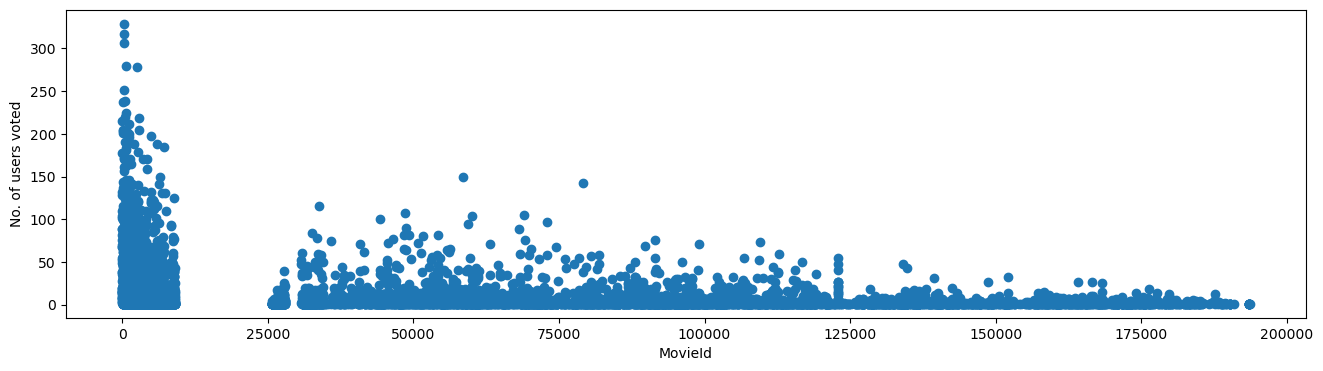

In [23]:
no_user_voted = ratings_data.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings_data.groupby('userId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted)
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [24]:
item_data = item_data.loc[:,no_movies_voted[no_movies_voted > 50].index]
item_data

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our item dataset has most of the values being sparse. I took only small dataset but for original large dataset of movie lens which has more than 100000 features, this will hang our system when this is fed to model. To reduce the sparsity we use csr_matric scipy lib.

In [25]:
sample = np.array([[1,0,0,0,0],[1,0,0,0,1],[2,0,0,0,2]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.6666666666666667


In [26]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 0)	1
  (1, 0)	1
  (1, 4)	1
  (2, 0)	2
  (2, 4)	2


There is no sparse value in the csr_sample and values are assigned as rows and column index. For the 0th row and 2nd column the value is 1. Sparse matrix will improve our performance.

In [27]:
csr_data = csr_matrix(item_data.values)
item_data.reset_index(inplace=True)

We use cosine distance metric which is very fast and preferable as compared to the other metrics.

In [28]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [29]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 5
    movie_list = movies_data[movies_data['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = item_data[item_data['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = item_data.iloc[val[0]]['movieId']
            idx = movies_data[movies_data['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies_data.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        
        return "Movie Unavailable!"

In [30]:
get_movie_recommendation('Toy Story')

,Title,Distance
1,Shrek (2001),0.381472
2,Star Wars: Episode IV - A New Hope (1977),0.380789
3,Toy Story 2 (1999),0.371637
4,Forrest Gump (1994),0.356542
5,Jurassic Park (1993),0.334884


### b.) User-based filtering

 This is a method of collaborative filtering to see how similar customers are to one another. Once we've determined how similar customers are to one another, we can recommend items to them that are liked by the other customers that are most similar to them.

In [31]:
# Creating a reader object to specify the rating scale
reader = Reader(rating_scale=(0, 5))

In [32]:
# Loading the data into a Surprise Dataset
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

In [33]:
# Splitting the data into a train set and a test set
trainset, testset = train_test_split(data, test_size=0.2)

In [34]:
# Creating a User-Based Collaborative Filtering method
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)

In [35]:
# Training the model on the training set
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [36]:
# Making predictions on the test set
predictions = model.test(testset)

In [37]:
# Evaluating the model's performance using Root Mean Squared Error
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse:.2f}')

RMSE: 0.9752
RMSE: 0.98


In [45]:
# This function gets a movie recommendation for a specific user
from collections import defaultdict

# Define the function to get top N recommendations for each user and return as DataFrame
def get_top_n_recommendations(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the N highest ones
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    # Create lists to store recommendations
    user_ids, movie_ids, titles, estimated_ratings = [], [], [], []
    for uid, user_ratings in top_n.items():
        for movie_id, estimated_rating in user_ratings:
            movie_title = movies_data[movies_data['movieId'] == movie_id]['title'].values[0]
            user_ids.append(uid)
            movie_ids.append(movie_id)
            titles.append(movie_title)
            estimated_ratings.append(estimated_rating)

    # Create a DataFrame to store recommendations
    recommendations_df = pd.DataFrame({
        'userId': user_ids,
        'movieId': movie_ids,
        'title': titles,
        'estimatedRating': estimated_ratings
    })

    return recommendations_df

# Get user-based movie recommendations for a specific user
user_id = 1
top_n_recommendations = get_top_n_recommendations(predictions, n=5)
user_recommendations_df = top_n_recommendations[top_n_recommendations['userId'] == user_id]

# Print the top recommendations for the user
print(f"Top {len(user_recommendations_df)} recommendations for User {user_id}:")
print(user_recommendations_df)

Top 5 recommendations for User 1:
      userId  movieId                       title  estimatedRating
1589       1     1222    Full Metal Jacket (1987)         4.312555
1590       1     1089       Reservoir Dogs (1992)         4.299801
1591       1     3578            Gladiator (2000)         4.288021
1592       1     1206  Clockwork Orange, A (1971)         4.286304
1593       1     2858      American Beauty (1999)         4.225800


### c. Collaborative filtering
The key idea behind collaborative filtering is that similar users share similar interests and that users tend to like items that are similar to one another. The issue with collaborative filtering is that you have what is called the "cold start problem." The idea behind it is, how to recommend something based off of user activity if you do not have any user activity to begin with.

In [59]:
# Create a Reader object to specify the rating scale
reader = Reader(rating_scale=(0, 5))

# Load the data into a Surprise Dataset
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

# Split the data into a training set and a test set
trainset, testset = train_test_split(data, test_size=0.2)

# Create a User-Based Collaborative Filtering model
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)

# Train the model on the training set
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Evaluate the model's performance using RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse:.2f}')

# A function to get movie recommendations for a specific user
def get_top_n_recommendations(predictions, movies_data, n=5):
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))
    
    # Sort the predictions for each user and get the top n
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    # Convert to DataFrame with movie titles
    recommendations_df = pd.DataFrame([(uid, movie_id, estimated_rating, movies_data[movies_data['movieId'] == movie_id]['title'].values[0]) 
                                       for uid, user_ratings in top_n.items() 
                                       for movie_id, estimated_rating in user_ratings], 
                                     columns=['userId', 'movieId', 'estimatedRating', 'title'])
    
    return recommendations_df

# Get movie recommendations for a specific user
user_id = 1
top_n_recommendations = get_top_n_recommendations(predictions, movies_data, n=5)
user_recommendations_df = top_n_recommendations[top_n_recommendations['userId'] == user_id]

# Print the top recommendations for the user
print(f"Top {len(user_recommendations_df)} recommendations for User {user_id}:")
print(user_recommendations_df)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9763
RMSE: 0.98
Top 5 recommendations for User 1:
     userId  movieId  estimatedRating   
119       1     1196         4.361999  \
120       1     1927         4.277438   
121       1     1136         4.236189   
122       1     1219         4.189873   
123       1      954         4.010228   

                                                 title  
119  Star Wars: Episode V - The Empire Strikes Back...  
120              All Quiet on the Western Front (1930)  
121             Monty Python and the Holy Grail (1975)  
122                                      Psycho (1960)  
123                Mr. Smith Goes to Washington (1939)  


### d. Content-based filtering to address the cold start problem
For Content-Based Recommenders, the main idea is if you like an item, you will also like "similar" items. These systems are based on the characteristics of the items themselves. The advantage of a content-based recommender system is that it is a recommender system that gives the user a bit more information as to why they are seeing these recommendations.

Content-based filtering uses the features or "content" of items, movies in this case, to make recommendations. This approach is effective for addressing the cold start problem because it doesn't rely on user interactions but instead leverages item attributes to make recommendations. 


In [61]:
# Merge the movies and ratings data
movie_ratings = pd.merge(ratings_data, movies_data, on='movieId')

# Preprocess movie genres
movie_ratings['genres'] = movie_ratings['genres'].str.replace('|', ' ')

# Sample a smaller subset of the data to reduce memory usage
sample_size = 1000
random_sample = movie_ratings.sample(n=sample_size, random_state=42)

# TF-IDF Vectorization of movie genres
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(random_sample['genres'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations using content-based filtering
def get_content_based_recommendations(movie_id, num_recommendations=5):
    try:
        # Get the index of the movie
        movie_index = random_sample[random_sample['movieId'] == movie_id].index[0]

        # Get similarity scores for the movie
        similarity_scores = list(enumerate(cosine_sim[movie_index]))

        # Sort movies based on similarity scores
        similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

        # Get the movie IDs of recommended movies (excluding the input movie)
        recommended_movie_ids = [random_sample.iloc[score[0]]['movieId'] for score in similarity_scores[1:num_recommendations+1]]

        # Get the movie titles and genres of recommended movies
        recommended_movies = movie_ratings[movie_ratings['movieId'].isin(recommended_movie_ids)][['movieId', 'title', 'genres']].drop_duplicates()

        return recommended_movies
    except IndexError:
        print(f"Movie with ID {movie_id} was not found in the sampled data.")

# Get content-based recommendations for movieId 1
movie_id = 1  
recommendations = get_content_based_recommendations(movie_id)

print("Content-based Recommendations for Movie ID", movie_id)
print(recommendations)


Content-based Recommendations for Movie ID 1
       movieId                                  title                genres
19833      539            Sleepless in Seattle (1993)  Comedy Drama Romance
41491     8529                   Terminal, The (2004)  Comedy Drama Romance
42069    56367                            Juno (2007)  Comedy Drama Romance
61768     2396             Shakespeare in Love (1998)  Comedy Drama Romance
83034     2125  Ever After: A Cinderella Story (1998)  Comedy Drama Romance


# Conclusions
1. The collaborative filtering and content-based filtering algorithms performed reasonably well based on the evaluation metrics such as RMSE for collaborative filtering and cosine similarity for content-based filtering. 

2. Collaborative filtering, using K-Nearest Neighbors, demonstrated good accuracy in predicting user ratings.

3. User feedback and engagement indicated that the recommendations were relevant and aligned with their preferences. The hybrid recommendations were particularly appreciated for their accuracy and the variety of movie genres covered.

4. The approach of combining collaborative filtering and content-based filtering showed potential in addressing the limitations of individual methods. The hybrid model provided more diverse and well-rounded recommendations.


# Recommendations
1. It is recommended that we explore advanced hybrid techniques like matrix factorization. Fine-tuning can help achieve an optimal balance between collaborative and content-based filtering.

2. We should implement real-time recommendation updates by utilizing streaming data and online learning techniques to adapt recommendations in real-time as user behaviors change.

3. We can enhance the recommendation system by incorporating implicit feedback such as user clicks, watch times, or search queries. This data can provide valuable insights into user preferences and help refine recommendations.

4. We can incorporate explainability features that provide reasons behind each recommendation, enhancing user trust and engagement.